<a href="https://colab.research.google.com/github/jessalynlc/IDS705_final_project/blob/main/data_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import requests
import json
import pandas as pd
import numpy as np

In [12]:
%reset -f


# 1. Data Preparation

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 2. Feature Engineering

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

## 2.1 Target Variable

C:\Users\butterfly\AppData\Local\Temp\ipykernel_2704\1310018011.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])


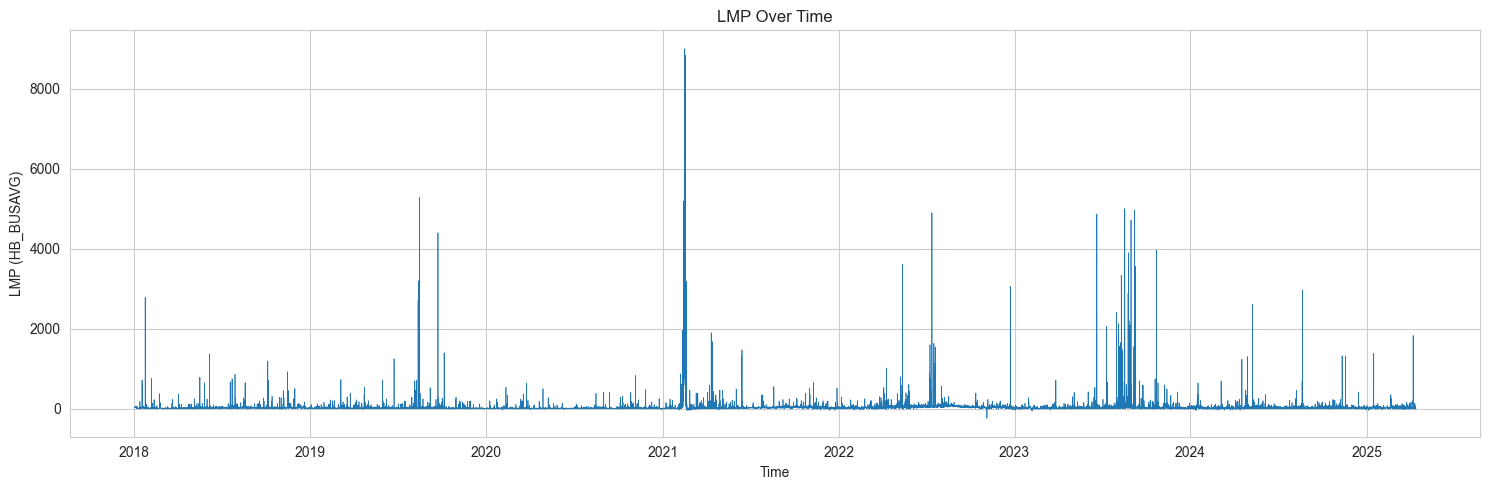

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

#
df = pd.read_csv('all_hourly_data.csv')

#
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])

#
df = df.sort_values('interval_start_local')

#
plt.figure(figsize=(15, 5))
plt.plot(df['interval_start_local'], df['lmp_HB_BUSAVG'], linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('LMP (HB_BUSAVG)')
plt.title('LMP Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


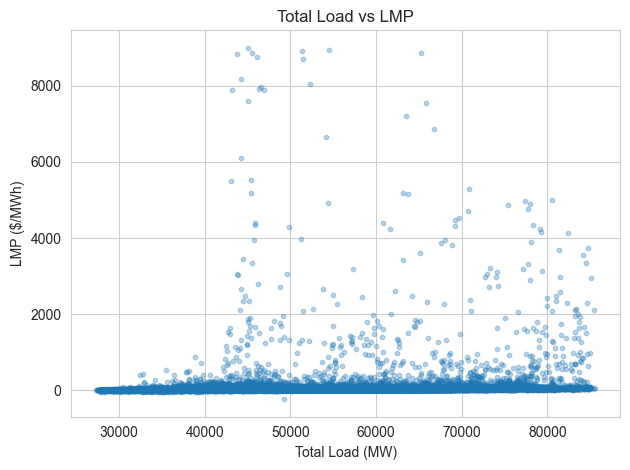

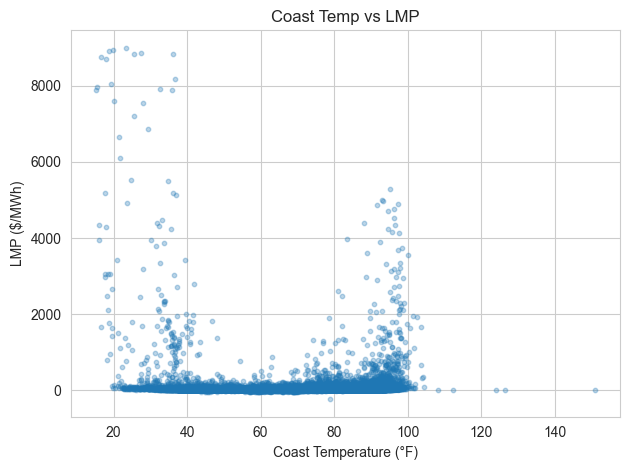

In [3]:
import matplotlib.pyplot as plt

# 1) total_load vs LMP
plt.figure()
plt.scatter(df['total_load'], df['lmp_HB_BUSAVG'], s=10, alpha=0.3)
plt.xlabel('Total Load (MW)')
plt.ylabel('LMP ($/MWh)')
plt.title('Total Load vs LMP')
plt.tight_layout()
plt.show()

# 2) 不同区域温度 vs LMP（以 coast_temp 为例）
plt.figure()
plt.scatter(df['coast_temp'], df['lmp_HB_BUSAVG'], s=10, alpha=0.3)
plt.xlabel('Coast Temperature (°F)')
plt.ylabel('LMP ($/MWh)')
plt.title('Coast Temp vs LMP')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

#
series = df['lmp_HB_BUSAVG']

#
result = adfuller(series, maxlag=12, regression='c')  #

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value:        {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#
series = df['lmp_HB_BUSAVG'].dropna()

#
plt.figure()
plot_acf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of lmp_HB_BUSAVG')
plt.tight_layout()
plt.show()

#
plt.figure()
plot_pacf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF of lmp_HB_BUSAVG')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df['lmp_HB_BUSAVG'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 提取目标变量
lmp = df['lmp_HB_BUSAVG']

# 计算统计量
mean_val = lmp.mean()
median_val = lmp.median()
std_val = lmp.std()
skew_val = skew(lmp)
kurt_val = kurtosis(lmp)  # Fisher's definition (normal dist = 0)

# 打印统计量
print(f"✅ LMP Summary Statistics:")
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {std_val:.2f}")
print(f"Skewness: {skew_val:.2f}")
print(f"Kurtosis: {kurt_val:.2f}")

# 分布图
plt.figure(figsize=(10, 5))
sns.histplot(lmp, bins=100, kde=True, color='skyblue')
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.1.1 Log Transformation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 转换时间格式，确保正确排序
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])
df = df.sort_values('interval_start_local')

# 对 LMP 进行对数变换（注意加 1 避免 log(0) 的情况）
df['lmp_log'] = np.log(df['lmp_HB_BUSAVG'] + 1)

# 绘制变换后的 LMP 随时间变化趋势图
plt.figure(figsize=(15, 5))
plt.plot(df['interval_start_local'], df['lmp_log'], linewidth=0.8, label='Log(lmp + 1)')
plt.xlabel('Time')
plt.ylabel('Log(LMP + 1)')
plt.title('Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.2 Feature Engineering

In [2]:
import pandas as pd
import numpy as np

#
df = pd.read_csv('all_hourly_data.csv')

#
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek  #
df['day_of_month'] = df['interval_start_local'].dt.day       #
df['month']        = df['interval_start_local'].dt.month     #


# Lag Features
for lag in [1, 2, 3, 4, 5, 6, 7, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

# Rolling Features
df['lmp_roll_mean_24'] = df['lmp_HB_BUSAVG'].rolling(window=24).mean()
df['lmp_roll_mean_48'] = df['lmp_HB_BUSAVG'].rolling(window=48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(window=168).mean()


#
df = df.dropna().reset_index(drop=True)


In [15]:
#
print(df.isnull().sum())

interval_start_local    0
date                    0
hour                    0
north_x_load            0
south_load              0
west_x_load             0
houston_load            0
total_load              0
lmp_HB_BUSAVG           0
coal_and_lignite        0
hydro                   0
nuclear                 0
power_storage           0
solar                   0
wind                    0
natural_gas             0
other_gen               0
coast_temp              0
east_temp               0
far_west_temp           0
north_y_temp            0
north_central_temp      0
south_central_temp      0
southern_temp           0
west_y_temp             0
day_of_week             0
day_of_month            0
month                   0
lmp_lag_1               0
lmp_lag_2               0
lmp_lag_3               0
lmp_lag_4               0
lmp_lag_5               0
lmp_lag_6               0
lmp_lag_7               0
lmp_lag_24              0
lmp_lag_48              0
lmp_roll_mean_24        0
lmp_roll_mea

## 2.3 Train-test Split

In [3]:
import pandas as pd


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')



#
mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

#
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)

#
print(f"training samples: {train_df.shape[0]}, features: {train_df.shape[1]}")
print(f"testing samples：{test_df.shape[0]}, features:{test_df.shape[1]}")


training samples: 52349, features: 40
testing samples：11166, features:40


# 3.Boosting

## 3.1 Xgboost

### 3.1.1 baseline model

Test MSE:  5150.9154
Test RMSE: 71.7699
Test MAE:  28.2033


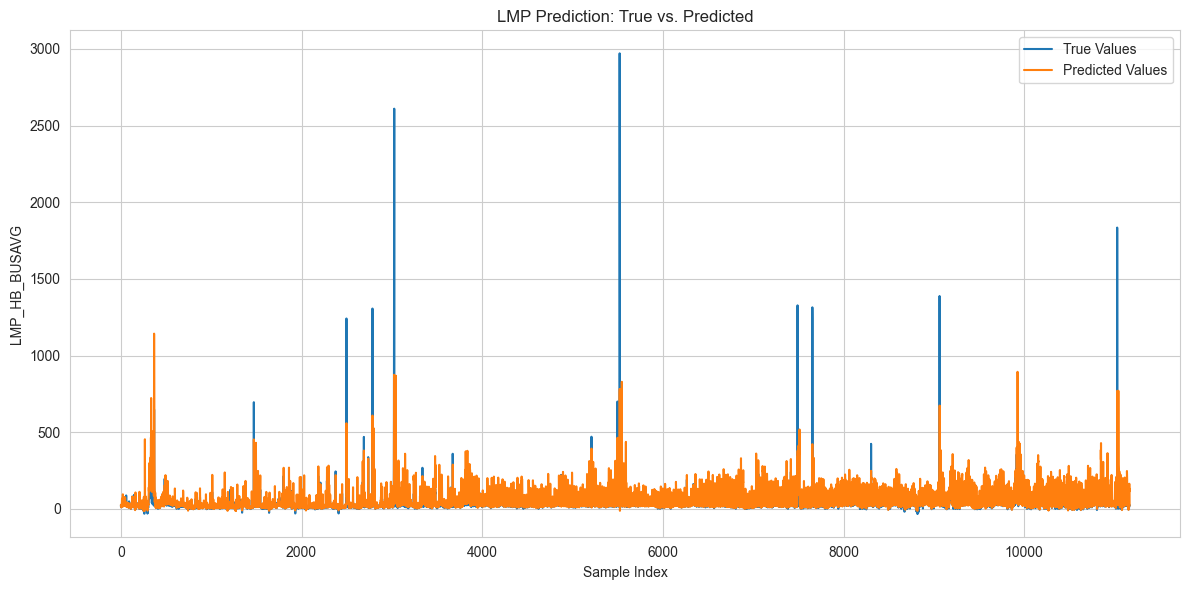

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 4. Prepare feature matrix and target vector
exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [col for col in train_df.columns if col not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

# 5. Train XGBoost regressor
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Compute evaluation metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# 8. Plot true vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred,         label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('LMP_HB_BUSAVG')
plt.title('LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()

### 3.1.2 feature importance

               feature  importance
25           lmp_lag_1    0.194740
17        north_y_temp    0.153826
26           lmp_lag_2    0.077398
18  north_central_temp    0.063829
12         natural_gas    0.048137
10               solar    0.042470
15           east_temp    0.041928
22         day_of_week    0.041348
34    lmp_roll_mean_24    0.028450
27           lmp_lag_3    0.022871
11                wind    0.021680
5           total_load    0.016338
28           lmp_lag_4    0.015707
20       southern_temp    0.015432
13           other_gen    0.014351
29           lmp_lag_5    0.014136
2           south_load    0.013332
7                hydro    0.013330
14          coast_temp    0.013321
32          lmp_lag_24    0.012585
31           lmp_lag_7    0.011854
9        power_storage    0.011326
3          west_x_load    0.010635
16       far_west_temp    0.009970
19  south_central_temp    0.009960
35    lmp_roll_mean_48    0.008652
23        day_of_month    0.008633
33          lmp_lag_

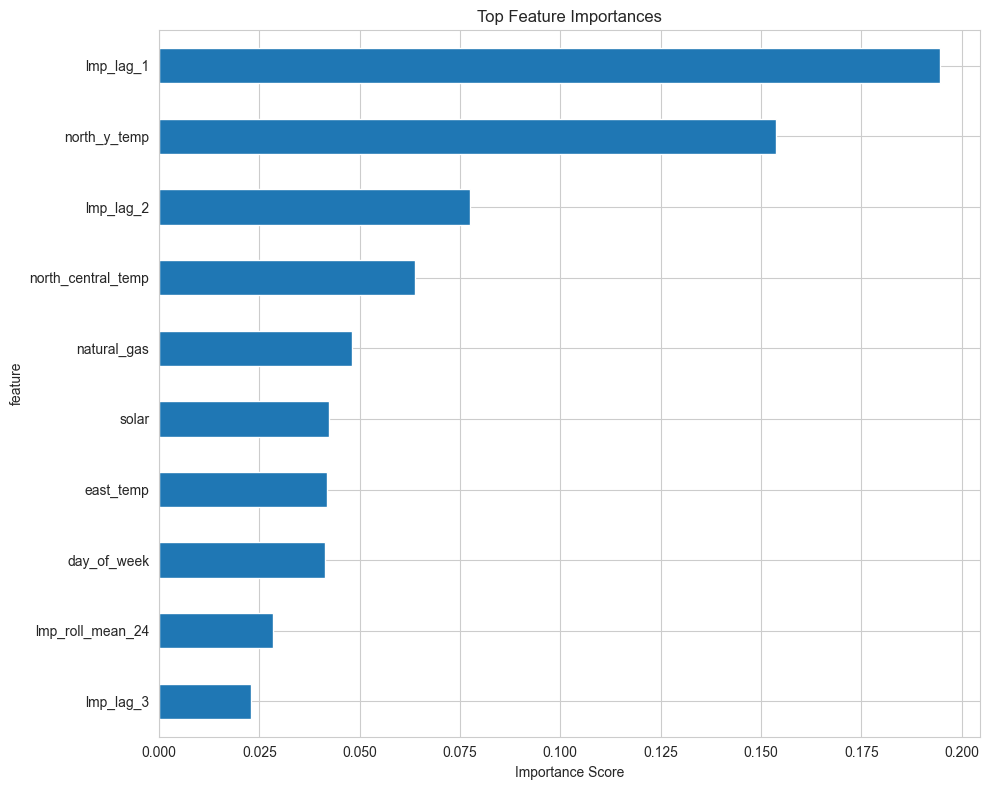

In [19]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

               feature  importance
9        power_storage  911.091234
34    lmp_roll_mean_24  664.258195
25           lmp_lag_1  485.943275
19  south_central_temp  400.661635
10               solar  258.797121
28           lmp_lag_4  155.459111
3          west_x_load  127.055407
6     coal_and_lignite  106.952893
20       southern_temp  106.898967
31           lmp_lag_7  106.379325
4         houston_load   88.485527
27           lmp_lag_3   87.847218
0                 hour   87.356524
32          lmp_lag_24   87.083261
18  north_central_temp   70.248433
26           lmp_lag_2   61.706991
14          coast_temp   57.706283
12         natural_gas   56.335655
8              nuclear   43.277686
30           lmp_lag_6   34.002528
2           south_load   28.322404
29           lmp_lag_5   24.713701
17        north_y_temp   19.747828
35    lmp_roll_mean_48   19.476111
5           total_load   15.718157
36   lmp_roll_mean_168   15.558308
7                hydro   15.296401
15           east_te

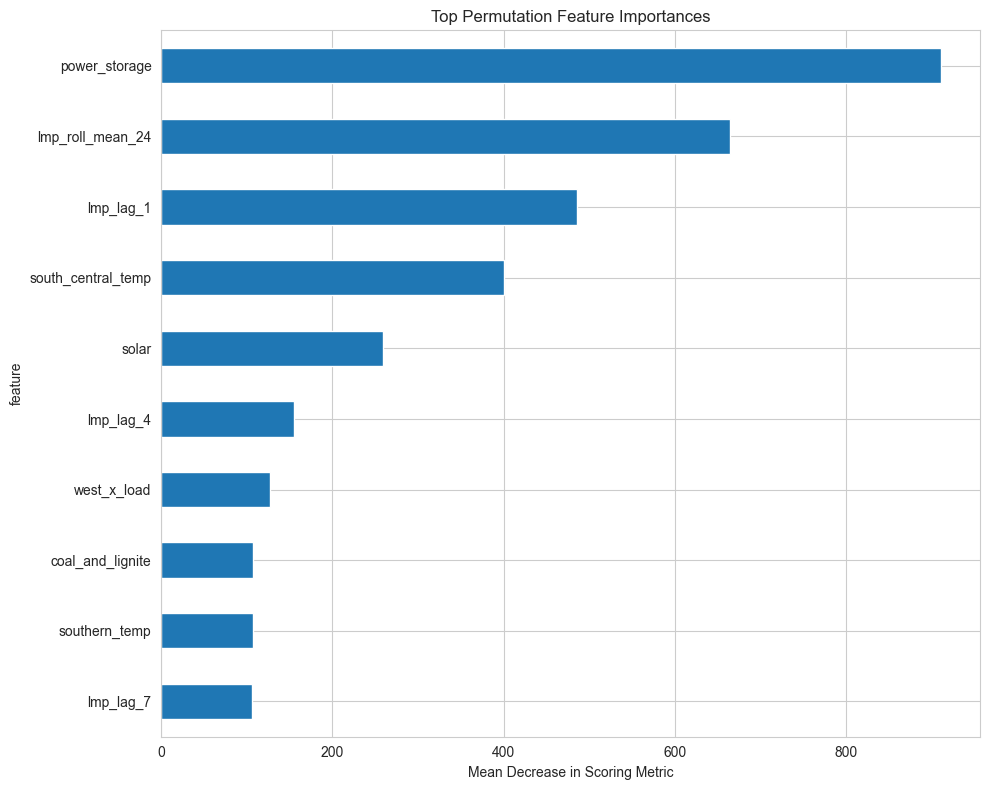

In [22]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt


result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)


perm_df = pd.DataFrame({
    'feature': X_test.columns,

    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)


print(perm_df)


top_n = 10
perm_df.head(top_n).plot(
    kind='barh',
    x='feature',
    y='importance',
    figsize=(10, 8),
    legend=False
)
plt.title("Top Permutation Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in Scoring Metric")
plt.tight_layout()
plt.show()


### 3.1.2 hyperparameter tunning

In [7]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    # 定义要调优的超参数空间
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),

        # 下面两行用来彻底关闭训练时的所有日志
        "verbosity": 0,
        "random_state": 42,

        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }

    # 构造并训练模型（verbose=False 也可再次确保没有日志输出）
    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # 在验证集上评估
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# 创建 Optuna study，最小化 RMSE
study = optuna.create_study(direction="minimize", study_name="xgb_lmp_tuning")
study.optimize(objective, n_trials=50, timeout=600)

# 输出最佳参数
print("Best RMSE: {:.4f}".format(study.best_value))
print("Best Params: ")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")

# 用最佳参数训练最终模型
best_params = study.best_params
# 一并加上 verbosity=0
best_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    verbosity=0
)
best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 最终评估
y_pred = best_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_test - y_pred))
print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


[I 2025-04-20 10:37:49,170] A new study created in memory with name: xgb_lmp_tuning
[I 2025-04-20 10:37:51,817] Trial 0 finished with value: 56.236039068039524 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.008447069727886024, 'subsample': 0.7603434281861033, 'colsample_bytree': 0.7885484130553508, 'gamma': 3.3341855006745256, 'reg_alpha': 3.6644298475792563, 'reg_lambda': 4.207183595947518}. Best is trial 0 with value: 56.236039068039524.
[I 2025-04-20 10:37:57,225] Trial 1 finished with value: 64.5299836195107 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.010439799201647362, 'subsample': 0.6989011513545644, 'colsample_bytree': 0.5037512759221996, 'gamma': 3.421851817937815, 'reg_alpha': 2.676381130106478, 'reg_lambda': 1.0948520702914304}. Best is trial 0 with value: 56.236039068039524.
[I 2025-04-20 10:38:05,329] Trial 2 finished with value: 65.80528533851158 and parameters: {'n_estimators': 791, 'max_depth': 4, 'learning_rate': 0

Best RMSE: 54.6977
Best Params: 
  n_estimators: 629
  max_depth: 9
  learning_rate: 0.004141262204215909
  subsample: 0.9011753689546691
  colsample_bytree: 0.6191627445379153
  gamma: 1.9398061892239116
  reg_alpha: 0.0461251569136345
  reg_lambda: 3.8527023414980794
Final Test RMSE: 54.6977, MAE: 15.0688


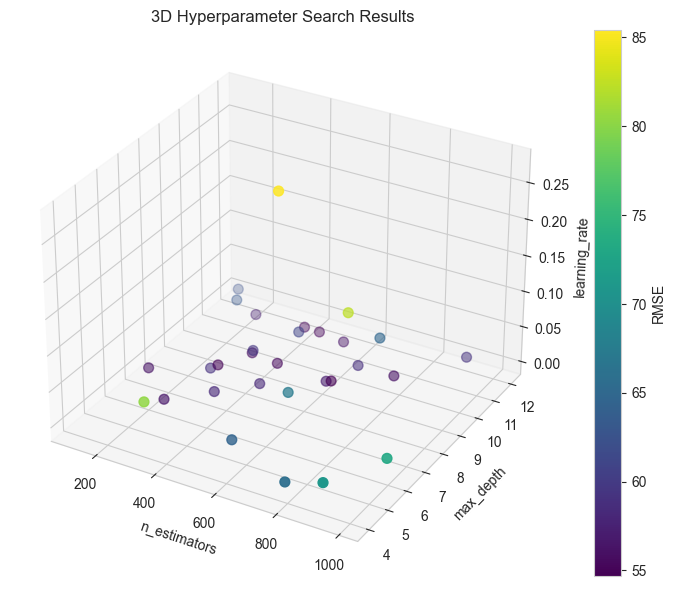

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 提取 trial 中的参数和值
xs = [t.params["n_estimators"]     for t in study.trials]
ys = [t.params["max_depth"]        for t in study.trials]
zs = [t.params["learning_rate"]    for t in study.trials]
vals = [t.value                     for t in study.trials]  # RMSE

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")
sc  = ax.scatter(xs, ys, zs, c=vals, cmap="viridis", s=50)
fig.colorbar(sc, ax=ax, label="RMSE")

ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth")
ax.set_zlabel("learning_rate")
ax.set_title("3D Hyperparameter Search Results")

plt.tight_layout()
plt.show()


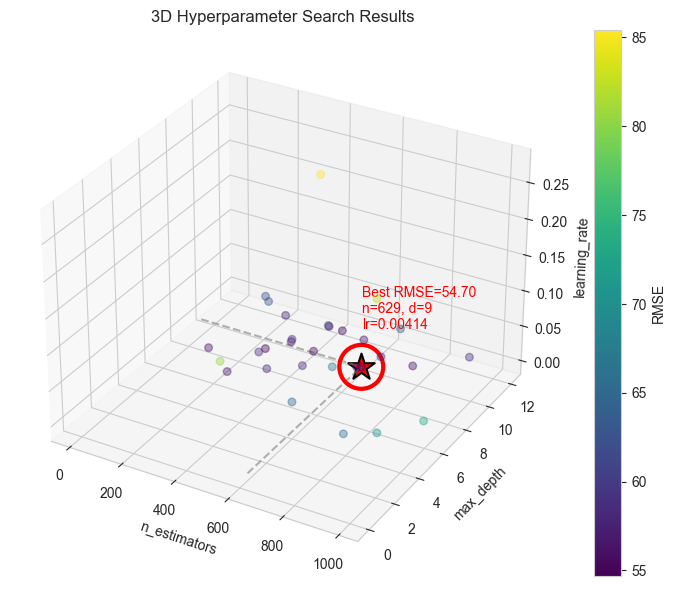

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 提取所有 trial 的参数和值
xs   = [t.params["n_estimators"]      for t in study.trials]
ys   = [t.params["max_depth"]         for t in study.trials]
zs   = [t.params["learning_rate"]     for t in study.trials]
vals = [t.value                        for t in study.trials]  # RMSE

# 最优 trial
best = study.best_trial
xb, yb, zb = (best.params["n_estimators"],
              best.params["max_depth"],
              best.params["learning_rate"])
vb = best.value  # 最优 RMSE

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")

# 弱化其他点
ax.scatter(xs, ys, zs,
           c=vals, cmap="viridis",
           s=30, alpha=0.4)

# 标出最优点：大红星
ax.scatter([xb], [yb], [zb],
           c="red", marker="*", s=400,
           edgecolors="k", linewidths=1.5)

# 外圈空心圆
ax.scatter([xb], [yb], [zb],
           facecolors='none', edgecolors='red',
           s=1000, linewidths=3)

# 投影参考线
ax.plot([xb, xb], [yb, yb], [0, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([xb, xb], [0, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([0, xb], [yb, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)

# —— 文字注释 ——
# 注意这里把文本放在比真实点稍高一点的位置 (zb + Δ)，避免跟星号重叠
ax.text(xb, yb, zb + 0.05,
        f"Best RMSE={vb:.2f}\nn={xb}, d={yb}\nlr={zb:.3g}",
        color="red", fontsize=10, ha="left", va="bottom")

# 设置轴、标题、色条
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth")
ax.set_zlabel("learning_rate")
ax.set_title("3D Hyperparameter Search Results")

mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
fig.colorbar(mappable, ax=ax, label="RMSE")

plt.tight_layout()
plt.show()


## 3.2 Lightgbm

### 3.2.1 baseline model

In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [c for c in train_df.columns if c not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

#
model = lgb.LGBMRegressor(
    objective='regression',   #
    metric='rmse',            #
    num_leaves=31,            #
    learning_rate=0.05,       #
    n_estimators=500,         #
    subsample=0.8,            #
    colsample_bytree=0.8,     #
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

#
y_pred = model.predict(X_test)

#
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8274
[LightGBM] [Info] Number of data points in the train set: 52349, number of used features: 37
[LightGBM] [Info] Start training from score 42.823374
 MSE:  5274.2836
RMSE: 72.6243
 MAE:  28.7075


### 3.2.2 feature importance

               feature  importance
17        north_y_temp        1221
25           lmp_lag_1        1201
34    lmp_roll_mean_24         855
15           east_temp         852
13           other_gen         804
16       far_west_temp         792
19  south_central_temp         784
9        power_storage         526
7                hydro         466
26           lmp_lag_2         462
12         natural_gas         419
11                wind         413
10               solar         405
20       southern_temp         397
32          lmp_lag_24         373
33          lmp_lag_48         365
6     coal_and_lignite         364
27           lmp_lag_3         339
18  north_central_temp         315
14          coast_temp         312
3          west_x_load         312
31           lmp_lag_7         299
28           lmp_lag_4         285
35    lmp_roll_mean_48         284
0                 hour         270
30           lmp_lag_6         267
21         west_y_temp         198
29           lmp_lag

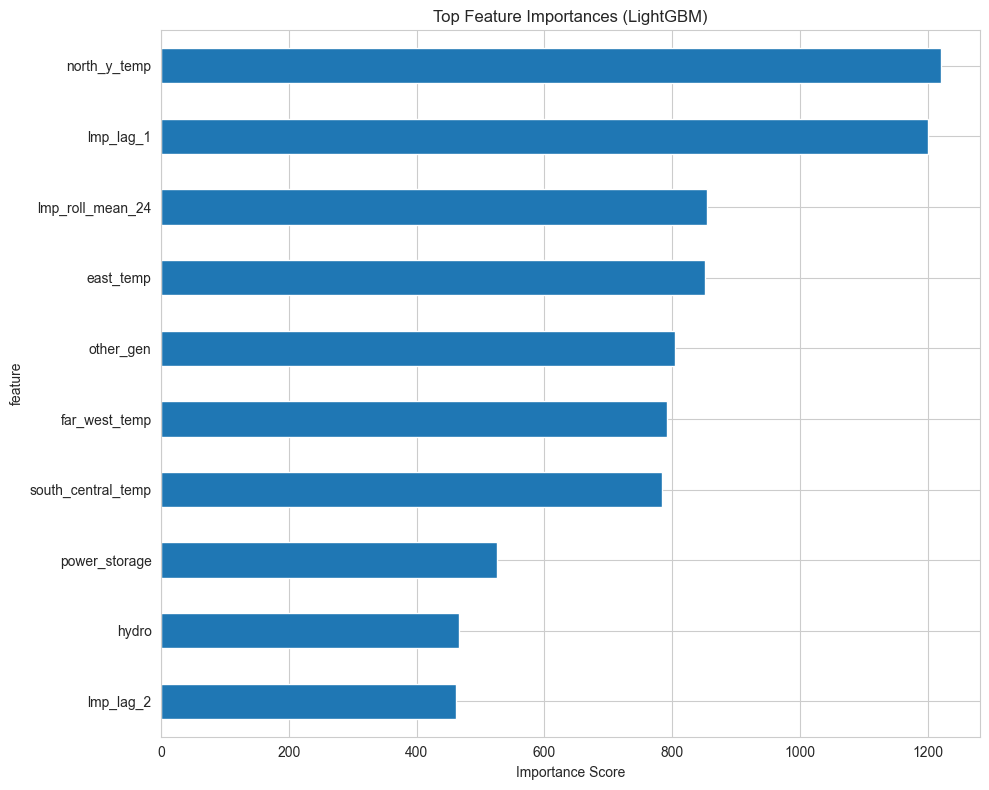

In [12]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (LightGBM)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

               feature  importance
9        power_storage  911.091234
34    lmp_roll_mean_24  664.258195
25           lmp_lag_1  485.943275
19  south_central_temp  400.661635
10               solar  258.797121
28           lmp_lag_4  155.459111
3          west_x_load  127.055407
6     coal_and_lignite  106.952893
20       southern_temp  106.898967
31           lmp_lag_7  106.379325
4         houston_load   88.485527
27           lmp_lag_3   87.847218
0                 hour   87.356524
32          lmp_lag_24   87.083261
18  north_central_temp   70.248433
26           lmp_lag_2   61.706991
14          coast_temp   57.706283
12         natural_gas   56.335655
8              nuclear   43.277686
30           lmp_lag_6   34.002528
2           south_load   28.322404
29           lmp_lag_5   24.713701
17        north_y_temp   19.747828
35    lmp_roll_mean_48   19.476111
5           total_load   15.718157
36   lmp_roll_mean_168   15.558308
7                hydro   15.296401
15           east_te

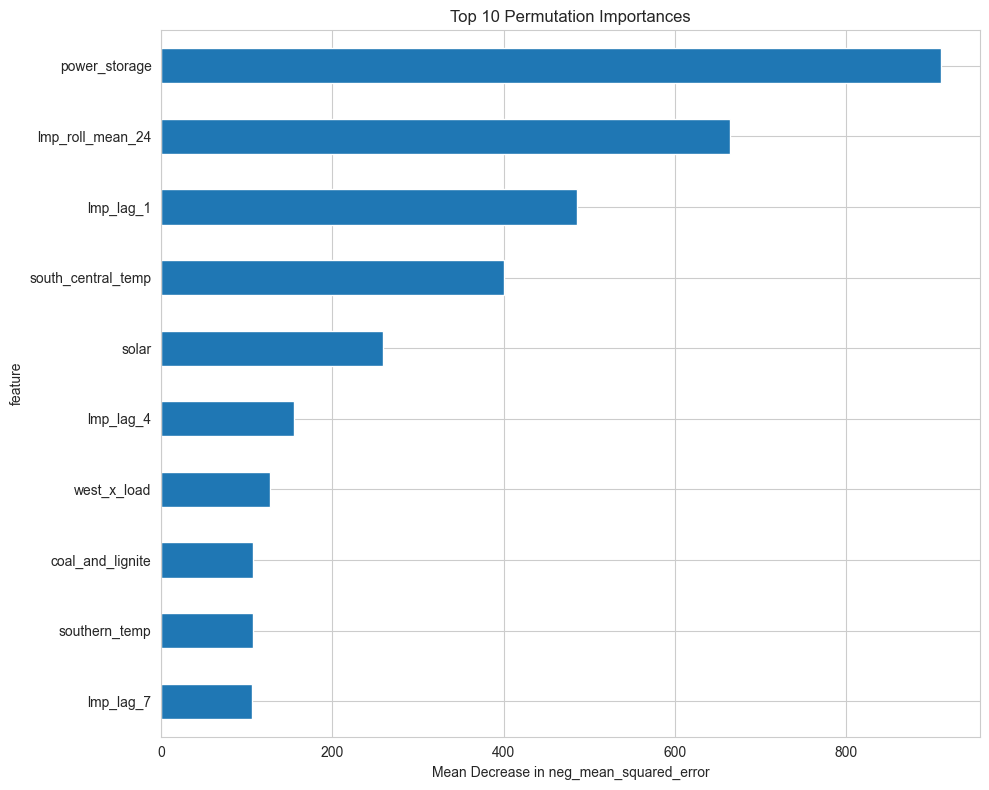

In [13]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# permutation importance
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)


perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)


top_n = 10
perm_df.head(top_n).plot(
    kind='barh',
    x='feature',
    y='importance',
    figsize=(10, 8),
    legend=False
)
plt.title(f"Top {top_n} Permutation Importances")
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in neg_mean_squared_error")
plt.tight_layout()
plt.show()


### 3.2.3 hyperparameter tuning

In [16]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    # 定义要调优的超参数空间
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 5.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),

        # 方法一：在构造器里关闭 LightGBM 内部的所有日志
        "verbosity": -1,
        # 如果你的 LightGBM 版本较老，也可以用 "silent": True

        "random_state": 42
    }

    # 构造并训练模型（n_estimators=1000，配合 early stopping）
    gbm = lgb.LGBMRegressor(**params, n_estimators=1000)
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)]
        # 不再传 verbose 参数
    )

    # 在测试集上计算 RMSE
    preds = gbm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# 创建 Optuna study，最小化 RMSE
study = optuna.create_study(direction="minimize", study_name="lgb_lmp_tuning")
study.optimize(objective, n_trials=50, timeout=600)

# 输出最佳结果
print("Best RMSE: {:.4f}".format(study.best_value))
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# 用最佳参数训练最终模型
best_params = study.best_params
final_model = lgb.LGBMRegressor(
    **best_params,
    objective="regression",
    metric="rmse",
    n_estimators=1000,
    verbosity=-1,       # 同样关闭日志
    random_state=42
)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

# 最终评估
y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_test - y_pred))
print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


[I 2025-04-20 10:54:29,171] A new study created in memory with name: lgb_lmp_tuning
[I 2025-04-20 10:54:43,029] Trial 0 finished with value: 54.16641867408542 and parameters: {'num_leaves': 33, 'max_depth': 9, 'learning_rate': 0.001648398729281186, 'min_child_samples': 14, 'min_split_gain': 0.8433351761546704, 'subsample': 0.6200611951594615, 'subsample_freq': 8, 'colsample_bytree': 0.9044714467880188, 'reg_alpha': 0.43845920255123405, 'reg_lambda': 2.2810641511164462}. Best is trial 0 with value: 54.16641867408542.
[I 2025-04-20 10:54:49,499] Trial 1 finished with value: 67.79834716765043 and parameters: {'num_leaves': 138, 'max_depth': 9, 'learning_rate': 0.041671621936668575, 'min_child_samples': 17, 'min_split_gain': 1.5852221108316067, 'subsample': 0.8263577822383416, 'subsample_freq': 6, 'colsample_bytree': 0.8046349256459832, 'reg_alpha': 1.9061989818115093, 'reg_lambda': 1.8717899285144624}. Best is trial 0 with value: 54.16641867408542.
[I 2025-04-20 10:54:58,359] Trial 2 fini

Best RMSE: 52.1352
Best params:
  num_leaves: 69
  max_depth: 5
  learning_rate: 0.0020746841271199754
  min_child_samples: 9
  min_split_gain: 2.099585102695656
  subsample: 0.8042350967843676
  subsample_freq: 4
  colsample_bytree: 0.9675132452975843
  reg_alpha: 4.732927628324875
  reg_lambda: 3.9275372349024638
Final Test RMSE: 52.1352, MAE: 13.1126


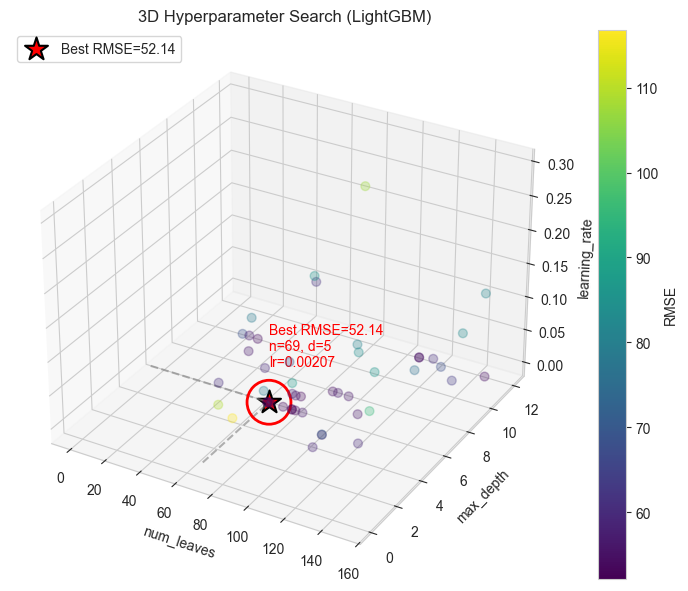

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 从 study 中提取三个超参数及对应的 RMSE：
xs   = [t.params["num_leaves"]       for t in study.trials]
ys   = [t.params["max_depth"]        for t in study.trials]
zs   = [t.params["learning_rate"]    for t in study.trials]
vals = [t.value                       for t in study.trials]  # RMSE

# 最优 trial
best = study.best_trial
xb, yb, zb = (
    best.params["num_leaves"],
    best.params["max_depth"],
    best.params["learning_rate"]
)
vb = best.value  # 最优 RMSE

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")

# 1) 画出所有点（半透明弱化）
ax.scatter(xs, ys, zs,
           c=vals,
           cmap="viridis",
           s=40,
           alpha=0.3)

# 2) 标出最优点：红星
ax.scatter([xb], [yb], [zb],
           c="red",
           marker="*",
           s=300,
           edgecolors="k",
           linewidths=1.5,
           label=f"Best RMSE={vb:.2f}")

# 3) 最优点空心圈加粗外框
ax.scatter([xb], [yb], [zb],
           facecolors="none",
           edgecolors="red",
           s=1000,
           linewidths=2)

# 4) 投影参考线（可选）
ax.plot([xb, xb], [yb, yb], [0, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([xb, xb], [0, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([0, xb], [yb, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)

# 5) 文本注释

ax.text(xb, yb, zb + 0.05,
        f"Best RMSE={vb:.2f}\nn={xb}, d={yb}\nlr={zb:.3g}",
        color="red", fontsize=10, ha="left", va="bottom")

# 设置轴标签和标题
ax.set_xlabel("num_leaves")
ax.set_ylabel("max_depth")
ax.set_zlabel("learning_rate")
ax.set_title("3D Hyperparameter Search (LightGBM)")

# 添加颜色条和图例
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
fig.colorbar(mappable, ax=ax, label="RMSE")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


# 4. RNNs

## 4.1 LSTM

### 4.1.1 Not standardization

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.lstm(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]           #
        return self.fc(out)           # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))


mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000626
Epoch 2/20, Train MSE=0.000610
Epoch 3/20, Train MSE=0.000607
Epoch 4/20, Train MSE=0.000606
Epoch 5/20, Train MSE=0.000605
Epoch 6/20, Train MSE=0.000603
Epoch 7/20, Train MSE=0.000602
Epoch 8/20, Train MSE=0.000601
Epoch 9/20, Train MSE=0.000602
Epoch 10/20, Train MSE=0.000601
Epoch 11/20, Train MSE=0.000601
Epoch 12/20, Train MSE=0.000599
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000600
Epoch 16/20, Train MSE=0.000600
Epoch 17/20, Train MSE=0.000599
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
 MSE:  4442.2925
RMSE: 66.6505
 MAE:  20.7884


In [ ]:
import optuna
from torch.utils.data import random_split

def get_data_loaders(trial, X, y):
    # 1) 采样序列长度和 batch size
    seq_len    = trial.suggest_int("seq_len", 12, 48, step=12)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # 构造带序列窗口的数据集
    dataset = TimeSeriesDataset(X, y, seq_len)
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val   = n_total - n_train

    # 随机拆分
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, seq_len

def objective(trial):
    # 2) 采样模型结构与优化器超参数
    hidden_size = trial.suggest_int("hidden_size", 32, 128, step=32)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    n_epochs    = trial.suggest_int("n_epochs", 5, 20)

    # 3) 重建 DataLoader（seq_len, batch_size）
    train_loader, val_loader, seq_len = get_data_loaders(
        trial, X_train_all, y_train_all
    )

    # 4) 实例化模型、损失和优化器
    model = LSTMRegressor(
        n_features=len(feature_cols),
        hidden_size=hidden_size,
        num_layers=num_layers
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 5) 训练若干轮
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(1), yb)
            loss.backward()
            optimizer.step()

    # 6) 验证集上计算平均 MSE
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb).squeeze(1)
            val_loss += criterion(y_pred, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    # Optuna 会最小化这个值
    return val_loss

# ---- 运行调优 ----
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best MSE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-04-20 11:35:37,712] A new study created in memory with name: no-name-3d508cc9-5757-4f03-8667-ecc0e62e5ac3
C:\Users\butterfly\AppData\Local\Temp\ipykernel_18328\3642119814.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the i

### 4.1.2 Standardization

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU use

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# — assume train_df and test_df are already loaded and preprocessed —

# 1. Select feature columns and target
exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# 2. Initialize StandardScalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# 3. Fit/transform train and transform test
X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

# 4. Dataset for sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        seq_x = self.X[idx : idx + self.seq_len]
        seq_y = self.y[idx + self.seq_len]
        return torch.FloatTensor(seq_x), torch.FloatTensor(seq_y)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

# 5. GRU model
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)            # [batch, seq_len, hidden_size]
        out     = out[:, -1, :]         # take last time step
        return self.fc(out)             # [batch, 1]

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Training loop
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze(1)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

# 7. Evaluation
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).squeeze(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(all_trues).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(all_preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=1.001506
Epoch 2/20, Train MSE=1.000933
Epoch 3/20, Train MSE=1.000788
Epoch 4/20, Train MSE=1.000645
Epoch 5/20, Train MSE=1.000575
Epoch 6/20, Train MSE=1.000491
Epoch 7/20, Train MSE=1.000567
Epoch 8/20, Train MSE=1.000455
Epoch 9/20, Train MSE=1.000593
Epoch 10/20, Train MSE=1.000489
Epoch 11/20, Train MSE=1.000509
Epoch 12/20, Train MSE=1.000449
Epoch 13/20, Train MSE=1.000524
Epoch 14/20, Train MSE=1.000502
Epoch 15/20, Train MSE=1.000442
Epoch 16/20, Train MSE=1.000439
Epoch 17/20, Train MSE=1.000433
Epoch 18/20, Train MSE=1.000473
Epoch 19/20, Train MSE=1.000404
Epoch 20/20, Train MSE=1.000446
Test MSE:  4525.3906
Test RMSE: 67.2710
Test MAE:  23.4316


## 4.2 GRU

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

#
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")

C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000699
Epoch 2/20, Train MSE=0.000626
Epoch 3/20, Train MSE=0.000619
Epoch 4/20, Train MSE=0.000619
Epoch 5/20, Train MSE=0.000612
Epoch 6/20, Train MSE=0.000613
Epoch 7/20, Train MSE=0.000606
Epoch 8/20, Train MSE=0.000607
Epoch 9/20, Train MSE=0.000606
Epoch 10/20, Train MSE=0.000603
Epoch 11/20, Train MSE=0.000604
Epoch 12/20, Train MSE=0.000602
Epoch 13/20, Train MSE=0.000601
Epoch 14/20, Train MSE=0.000602
Epoch 15/20, Train MSE=0.000601
Epoch 16/20, Train MSE=0.000601
Epoch 17/20, Train MSE=0.000601
Epoch 18/20, Train MSE=0.000601
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
测试集 MSE:  5094.9971
测试集 RMSE: 71.3792
测试集 MAE:  36.2598


# 5. day-ahead forecasting

## 5.1 xgboost

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#
df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)

#
df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

#
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

#
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)


df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']


model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

#
y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[0]	validation_0-rmse:218.18654	validation_1-rmse:68.09204
[10]	validation_0-rmse:160.97245	validation_1-rmse:75.67509
[20]	validation_0-rmse:127.01111	validation_1-rmse:82.47967
[30]	validation_0-rmse:105.91767	validation_1-rmse:94.93564
[40]	validation_0-rmse:93.66388	validation_1-rmse:100.55895
[50]	validation_0-rmse:85.60715	validation_1-rmse:109.06024
[60]	validation_0-rmse:80.39228	validation_1-rmse:123.72960
[70]	validation_0-rmse:76.14702	validation_1-rmse:145.55817
[80]	validation_0-rmse:73.13245	validation_1-rmse:156.43939
[90]	validation_0-rmse:70.26159	validation_1-rmse:157.85562
[100]	validation_0-rmse:68.21762	validation_1-rmse:164.50849
[110]	validation_0-rmse:66.02132	validation_1-rmse:175.61931
[120]	validation_0-rmse:64.21411	validation_1-rmse:181.39679
[130]	validation_0-rmse:62.56091	validation_1-rmse:181.92447
[140]	validation_0-rmse:60.72086	validation_1-rmse:183.95826
[150]	validation_0-rmse:59.22621	validation_1-rmse:187.64042
[160]	validation_0-rmse:57.84028	va

## 5.2 lightgbm

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)

#
df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

#
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

#
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)


df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']

#
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

#
y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7254
[LightGBM] [Info] Number of data points in the train set: 52349, number of used features: 33
[LightGBM] [Info] Start training from score 42.826536
24h 预测 — 测试集 MSE:  20723.2600
24h 预测 — 测试集 RMSE: 143.9558
24h 预测 — 测试集 MAE:  56.6976


## 5.3 LSTM

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)

df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000629
Epoch 2/20, Train MSE=0.000610
Epoch 3/20, Train MSE=0.000607
Epoch 4/20, Train MSE=0.000605
Epoch 5/20, Train MSE=0.000603
Epoch 6/20, Train MSE=0.000602
Epoch 7/20, Train MSE=0.000601
Epoch 8/20, Train MSE=0.000600
Epoch 9/20, Train MSE=0.000600
Epoch 10/20, Train MSE=0.000600
Epoch 11/20, Train MSE=0.000600
Epoch 12/20, Train MSE=0.000600
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000599
Epoch 16/20, Train MSE=0.000599
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000599
Epoch 19/20, Train MSE=0.000599
Epoch 20/20, Train MSE=0.000600
24h 预测 — 测试集 MSE:  4689.6997
24h 预测 — 测试集 RMSE: 68.4814
24h 预测 — 测试集 MAE:  28.1741


## 5.4 GRU

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month


for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)

df = df.dropna().reset_index(drop=True)
train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')
mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
scaler_x = MinMaxScaler(); scaler_y = MinMaxScaler()
X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.gru(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]        #
        return self.fc(out)        # [batch,1]

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred); ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))


mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000727
Epoch 2/20, Train MSE=0.000633
Epoch 3/20, Train MSE=0.000622
Epoch 4/20, Train MSE=0.000617
Epoch 5/20, Train MSE=0.000613
Epoch 6/20, Train MSE=0.000611
Epoch 7/20, Train MSE=0.000609
Epoch 8/20, Train MSE=0.000606
Epoch 9/20, Train MSE=0.000608
Epoch 10/20, Train MSE=0.000606
Epoch 11/20, Train MSE=0.000605
Epoch 12/20, Train MSE=0.000605
Epoch 13/20, Train MSE=0.000604
Epoch 14/20, Train MSE=0.000603
Epoch 15/20, Train MSE=0.000604
Epoch 16/20, Train MSE=0.000602
Epoch 17/20, Train MSE=0.000604
Epoch 18/20, Train MSE=0.000602
Epoch 19/20, Train MSE=0.000602
Epoch 20/20, Train MSE=0.000601
24h 预测 — 测试集 MSE:  4504.5312
24h 预测 — 测试集 RMSE: 67.1158
24h 预测 — 测试集 MAE:  22.2012
